# Credit Risk Analysis - The Quantum Way

* Why do we need credit risk analysis - Basel II and Basel III
* The Montecarlo methods, where they fall. Their complexity
* Enter QAE - A quick and non rigourous analysis on Brassard, Grover and others work
* QAE for Credit risk - mapping probability distributions


Work based on the following papers:

- <a href="https://www.nature.com/articles/s41534-019-0130-6">Quantum Risk Analysis. Stefan Woerner, Daniel J. Egger.</a> [Woerner2019]
- <a href="https://arxiv.org/abs/1907.03044">Credit Risk Analysis using Quantum Computers. Egger et al. (2019)</a> [Egger2019]
- <a href="http://arxiv.org/abs/quant-ph/0005055">Quantum Amplitude Amplification and Estimation. Gilles Brassard et al.</a>
- And many others, check the references and bibliography and have a blast

### Problem Definition

In this tutorial we want to analyze the credit risk of a portfolio of $K$ assets.
The default probability of every asset $k$ follows a *Gaussian Conditional Independence* model, i.e., given a value $z$ sampled from a latent random variable $Z$ following a standard normal distribution, the default probability of asset $k$ is given by

$$p_k(z) = F\left( \frac{F^{-1}(p_k^0) - \sqrt{\rho_k}z}{\sqrt{1 - \rho_k}} \right) $$

where $F$ denotes the cumulative distribution function of $Z$, $p_k^0$ is the default probability of asset $k$ for $z=0$ and $\rho_k$ is the sensitivity of the default probability of asset $k$ with respect to $Z$. Thus, given a concrete realization of $Z$ the individual default events are assumed to be independent from each other.

We are interested in analyzing risk measures of the total loss

$$ L = \sum_{k=1}^K \lambda_k X_k(Z) $$

where $\lambda_k$ denotes the _loss given default_ of asset $k$, and given $Z$, $X_k(Z)$ denotes a Bernoulli variable representing the default event of asset $k$. More precisely, we are interested in the expected value $\mathbb{E}[L]$, the Value at Risk (VaR) of $L$ and the Conditional Value at Risk of $L$ (also called Expected Shortfall). Where VaR and CVaR are defined as

$$ \text{VaR}_{\alpha}(L) = \inf \{ x \mid \mathbb{P}[L <= x] \geq 1 - \alpha \}$$

with confidence level $\alpha \in [0, 1]$, and

$$ \text{CVaR}_{\alpha}(L) = \mathbb{E}[ L \mid L \geq \text{VaR}_{\alpha}(L) ].$$

For more details on the considered model, see, e.g.,<br>
<a href="https://arxiv.org/abs/1412.1183">Regulatory Capital Modeling for Credit Risk. Marek Rutkowski, Silvio Tarca</a>



The problem is defined by the following parameters:
- number of qubits used to represent $Z$, denoted by $n_z$
- truncation value for $Z$, denoted by $z_{\text{max}}$, i.e., Z is assumed to take $2^{n_z}$ equidistant values in $\{-z_{max}, ..., +z_{max}\}$ 
- the base default probabilities for each asset $p_0^k \in (0, 1)$, $k=1, ..., K$
- sensitivities of the default probabilities with respect to $Z$, denoted by $\rho_k \in [0, 1)$
- loss given default for asset $k$, denoted by $\lambda_k$
- confidence level for VaR / CVaR $\alpha \in [0, 1]$.

In [135]:
import numpy as np
import matplotlib.pyplot as plt


from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute
from qiskit.circuit.library import IntegerComparator, LinearAmplitudeFunction, WeightedAdder
from qiskit.aqua.algorithms import IterativeAmplitudeEstimation

from qiskit.finance.applications import GaussianConditionalIndependenceModel as GCI

from kaleidoscope import probability_distribution


In [169]:
# Z represents our distribution, discretized with n qubits. The more qubits, the merrier. (I.e. the more values we will be able to approximate)
n_z = 3
z_max = 3
z_values = np.linspace(-z_max, z_max, 2**n_z)

# Probabilities of Default for each of our assets (p0k)
p_zeros = [0.15, 0.25]
K = len(p_zeros)
# Sensitivities respecto to Z, rhok
rhos = [0.1, 0.05]

# Loss given default. How much we lose based on the asset price
lgd = [1, 2]

# Confidence level for VaR and CVaR. On BaselII around 99,9%
alpha = 0.05

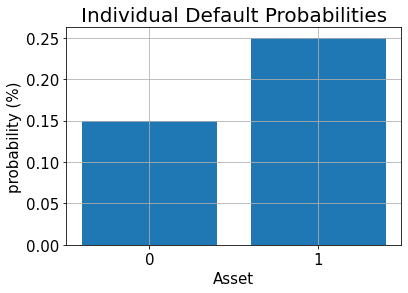

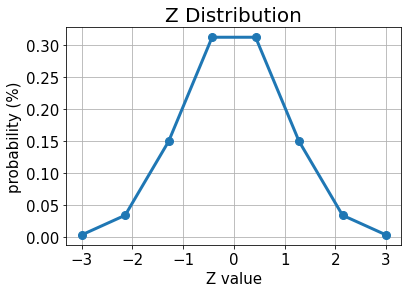

In [184]:
# plot results for default probabilities
plt.bar(range(K), p_zeros)
plt.xlabel('Asset', size=15)
plt.ylabel('probability (%)', size=15)
plt.title('Individual Default Probabilities', size=20)
plt.xticks(range(K), size=15)
plt.yticks(size=15)
plt.grid()
plt.show()

# plot results for Z
plt.plot(z_values, p_z, 'o-', linewidth=3, markersize=8)
plt.grid()
plt.xlabel('Z value', size=15)
plt.ylabel('probability (%)', size=15)
plt.title('Z Distribution', size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

### Uncertainty Model

We now construct a circuit that loads the uncertainty model. This can be achieved by creating a quantum state in a register of $n_z$ qubits that represents $Z$ following a standard normal distribution. This state is then used to control single qubit Y-rotations on a second qubit register of $K$ qubits, where a $|1\rangle$ state of qubit $k$ represents the default event of asset $k$. The resulting quantum state can be written as

$$ |\Psi\rangle = \sum_{i=0}^{2^{n_z}-1} \sqrt{p_z^i} |z_i \rangle \bigotimes_{k=1}^K \left( \sqrt{1 - p_k(z_i)}|0\rangle + \sqrt{p_k(z_i)}|1\rangle\right),$$

Where we denote by $z_i$ the $i$-th value of the discretized and truncated $Z$ [Egger2019].

In [170]:
uncertainty_model = GCI(n_z, z_max, p_zeros, rhos) 

In [171]:
job = execute(uncertainty_model, backend=Aer.get_backend('statevector_simulator'))
probability_distribution(job.result().get_counts())

In [172]:
# analyze uncertainty circuit and determine exact solutions
p_z = np.zeros(2**n_z)
p_default = np.zeros(K)
values = []
probabilities = []
num_qubits = uncertainty_model.num_qubits
for i, a in enumerate(job.result().get_statevector()):
    # get binary representation
    b = ('{0:0%sb}' % num_qubits).format(i)
    prob = np.abs(a)**2

    # extract value of Z and corresponding probability    
    # Note Z i mapped in the least significant n_z qubits. We add probabilities for each element in the distribution
    i_normal = int(b[-n_z:], 2)
    p_z[i_normal] += prob

    # determine overall default probability for k 
    # Most significant qubits represent 1 for default of that asset.
    loss = 0
    for k in range(K):
        if b[K - k - 1] == '1':
            p_default[k] += prob
            loss += lgd[k]
    values += [loss]
    probabilities += [prob]   

values = np.array(values)
probabilities = np.array(probabilities)
    
expected_loss = np.dot(values, probabilities)

losses = np.sort(np.unique(values))
pdf = np.zeros(len(losses))
for i, v in enumerate(losses):
    pdf[i] += sum(probabilities[values == v])
cdf = np.cumsum(pdf)

i_var = np.argmax(cdf >= 1-alpha)
exact_var = losses[i_var]
exact_cvar = np.dot(pdf[(i_var+1):], losses[(i_var+1):])/sum(pdf[(i_var+1):])

In [173]:
print('LGD: ', lgd, ' Total value: ', sum(lgd))
print('Assets: ', K)
print('Assets default Probabilities: ', p_zeros)
print('Expected Loss E[L]:                %.4f' % expected_loss)
print('Value at Risk VaR[L](%.2f):        %.4f' % (alpha, exact_var))
print('P[L <= VaR[L]](%.2f):              %.4f' % (alpha, cdf[exact_var]))
print('Conditional Value at Risk CVaR[L]: %.4f' % exact_cvar)

LGD:  [1, 2]  Total value:  3
Assets:  2
Assets default Probabilities:  [0.15, 0.25]
Expected Loss E[L]:                0.6414
Value at Risk VaR[L](0.05):        2.0000
P[L <= VaR[L]](0.05):              0.9588
Conditional Value at Risk CVaR[L]: 3.0000


### Expected Loss

To estimate the expected loss, we first apply a weighted sum operator to sum up individual losses to total loss:

$$ \mathcal{S}: |x_1, ..., x_K \rangle_K |0\rangle_{n_S} \mapsto |x_1, ..., x_K \rangle_K |\lambda_1x_1 + ... + \lambda_K x_K\rangle_{n_S}. $$

The required number of qubits to represent the result is given by

$$ n_s = \lfloor \log_2( \lambda_1 + ... + \lambda_K ) \rfloor + 1. $$

Once we have the total loss distribution in a quantum register, we can use the techniques described in [Woerner2019] to map a total loss $L \in \{0, ..., 2^{n_s}-1\}$ to the amplitude of an objective qubit by an operator

$$ | L \rangle_{n_s}|0\rangle \mapsto | L \rangle_{n_s} \left( \sqrt{1 - L/(2^{n_s}-1)}|0\rangle + \sqrt{L/(2^{n_s}-1)}|1\rangle \right),$$

which allows to run amplitude estimation to evaluate the expected loss.


Weighted Adder operator:

$$|q_0 \ldots q_{n-1}\rangle |0\rangle_s \mapsto |q_0 \ldots q_{n-1}\rangle |\sum_{j=0}^{n-1} \lambda_j q_j\rangle_s$$



                   ┌────────┐
          state_0: ┤0       ├ | state_0 * weights[0]
                   │        │ |
          state_1: ┤1       ├ | + state_1 * weights[1]
                   │        │ |
          state_2: ┤2       ├ | + state_2 * weights[2]
                   │        │ |
          state_3: ┤3       ├ | + state_3 * weights[3]
                   │        │
            sum_0: ┤4       ├ |
                   │  Adder │ |
            sum_1: ┤5       ├ | = sum_0 * 2^0 + sum_1 * 2^1 + sum_2 * 2^2
                   │        │ |
            sum_2: ┤6       ├ |
                   │        │
          carry_0: ┤7       ├
                   │        │
          carry_1: ┤8       ├
                   │        │
        control_0: ┤9       ├
                   └────────┘

In [174]:
# add Z qubits with weight/loss 0

# WeightedAdder(num_state_qubits=None, weights=None, name='adder')
# We need as many state qubits as our feinition of Z and number of assets: |x1,...xk>|0>ns
# We only add weights to the lgd elements of the sum and add 0 to the Z (not really adding them)
weighted_adder = WeightedAdder(n_z + K, [0]*n_z + lgd)
print(n_z + K)
print ([0]*n_z + lgd)

# Lets do a quick test to validate the WeightedAdder Qiskit function
test_adder = WeightedAdder(4, [0,0,1,1])



5
[0, 0, 0, 1, 2]


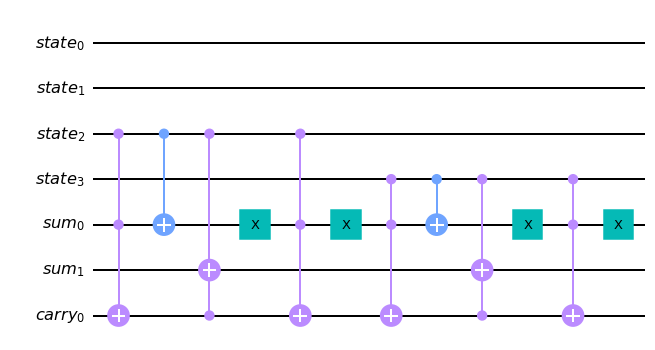

In [140]:
test_adder.draw('mpl')

In [141]:
# Test Aggregator

state_registry = QuantumRegister(test_adder.num_state_qubits, 'state')
sum_registry = QuantumRegister(test_adder.num_sum_qubits, 'sum')
carry_registry = QuantumRegister(test_adder.num_carry_qubits, 'carry')
sum_result = ClassicalRegister(test_adder.num_sum_qubits, 'sum_result')
carry_result = ClassicalRegister(test_adder.num_carry_qubits, 'carry_result')
if test_adder.num_control_qubits > 0:
    control_registry = QuantumRegister(test_adder.num_control_qubits, 'control')
    test_adder_circuit = QuantumCircuit(state_registry, sum_registry, carry_registry, control_registry, sum_result, carry_result)
else:
    test_adder_circuit = QuantumCircuit(state_registry, sum_registry, carry_registry, sum_result, carry_result)

test_adder_circuit.x(state_registry[0])
test_adder_circuit.x(state_registry[1])
test_adder_circuit.x(state_registry[2])
test_adder_circuit.x(state_registry[3])

#test_adder_circuit.x(sum_registry)
#test_adder_circuit.x(contro_registry[0])

test_adder_circuit.append(test_adder, range(test_adder.num_qubits))
test_adder_circuit.measure(sum_registry, sum_result)
test_adder_circuit.measure(carry_registry, carry_result)
test_adder_circuit.draw()



┌───┐┌────────┐         
       state_0: ┤ X ├┤0       ├─────────
                ├───┤│        │         
       state_1: ┤ X ├┤1       ├─────────
                ├───┤│        │         
       state_2: ┤ X ├┤2       ├─────────
                ├───┤│        │         
       state_3: ┤ X ├┤3 adder ├─────────
                └───┘│        │┌─┐      
         sum_0: ─────┤4       ├┤M├──────
                     │        │└╥┘┌─┐   
         sum_1: ─────┤5       ├─╫─┤M├───
                     │        │ ║ └╥┘┌─┐
       carry_0: ─────┤6       ├─╫──╫─┤M├
                     └────────┘ ║  ║ └╥┘
  sum_result: 2/════════════════╩══╩══╬═
                                0  1  ║ 
                                      ║ 
carry_result: 1/══════════════════════╩═
                                      0

In [142]:
job = execute(test_adder_circuit, backend=Aer.get_backend('statevector_simulator'))
probability_distribution(job.result().get_counts())

### Linear Amplitude Function 

CLASSLinearAmplitudeFunction(num_state_qubits, slope, offset, domain, image, rescaling_factor=1, breakpoints=None, name='F')

A circuit implementing a (piecewise) linear function on qubit amplitudes.

An amplitude function 𝐹 of a function 𝑓 is a mapping
$$F|x\rangle|0\rangle = \sqrt{1 - \hat{f}(x)} |x\rangle|0\rangle + \sqrt{\hat{f}(x)} |x\rangle|1\rangle.$$

for a function $ \hat{f}: \{0, ..., 2^n - 1\} \rightarrow [0, 1] $, where |𝑥⟩ is a $n$ qubit state.

This circuit implements F for piecewise linear functions $\hat{f}$. In this case, the mapping F can be approximately implemented using a Taylor expansion and linearly controlled Pauli-Y rotations. This approximation uses a rescaling_factor to determine the accuracy of the Taylor expansion.

In general, the function of interest f is defined from some interval $[a,b]$, 'domain' to $ [c,d]$, the 'image', instead of $ \{1, ..., N\} $ to $[0, 1]$. Usng an affine transformation we can rescale $f$ to $ \hat{f} $ :

$$\hat{f(x)} = \frac{f(\phi(x)) - c}{d - c}$$

with

$\phi(x) = a + \frac{b - a}{2^n - 1} x$

If $ f $ is a piecewise linear function on 'm' intervals $ [p_{i-1}, p_i], i \in \{1, ..., m\} $ with slopes $ \alpha_i $ and offsets $ \beta_i $ it can be written as

$$f(x) = \sum_{i=1}^m 1_{[p_{i-1}, p_i}(x) (\alpha_i x + \beta_i)$$

where $ 1_[a, b] $ is an indication function that is 1 if the argument is in the interval $ [a, b] $ and otherwise 0. The breakpoints $ p_i $ can be specified by the 'breakpoints' argument.

In [175]:

# define linear objective function
breakpoints = [0]
slopes = [1]
offsets = [0]
f_min = 0
f_max = sum(lgd)
c_approx = 0.25

objective = LinearAmplitudeFunction(
    weighted_adder.num_sum_qubits,
    slope=slopes, 
    offset=offsets, 
    # max value that can be reached by the qubit register (will not always be reached)
    domain=(0, 2**agg.num_sum_qubits-1),  
    image=(f_min, f_max),
    rescaling_factor=c_approx,
    breakpoints=breakpoints
)

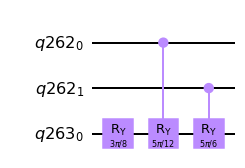

In [176]:
objective.decompose().draw('mpl')

In [177]:
job = execute(objective, backend=Aer.get_backend('statevector_simulator'))
probability_distribution(job.result().get_counts())

## Put everything together for the state preparation

In [178]:
# define the registers for convenience and readability
qr_state = QuantumRegister(uncertainty_model.num_qubits, 'state')
qr_sum = QuantumRegister(weighted_adder.num_sum_qubits, 'sum')
qr_carry = QuantumRegister(weighted_adder.num_carry_qubits, 'carry')
qr_obj = QuantumRegister(1, 'objective')

# define the circuit
state_preparation = QuantumCircuit(qr_state, qr_obj, qr_sum, qr_carry, name='A')

# load the random variable
#state_preparation.append(uncertainty_model.to_gate(), qr_state)
state_preparation.append(uncertainty_model, qr_state)

# aggregate
#state_preparation.append(weighted_adder.to_gate(), qr_state[:] + qr_sum[:] + qr_carry[:])
state_preparation.append(weighted_adder, qr_state[:] + qr_sum[:] + qr_carry[:])

# linear objective function
#state_preparation.append(objective.to_gate(), qr_sum[:] + qr_obj[:])
state_preparation.append(objective, qr_sum[:] + qr_obj[:])

# uncompute aggregation
state_preparation.append(weighted_adder.to_gate().inverse(), qr_state[:] + qr_sum[:] + qr_carry[:])

# draw the circuit
state_preparation.decompose().draw()

┌───────┐┌─────────┐┌─────────┐                                   »
    state_0: ┤0      ├┤0        ├┤0        ├───────────────────────────────────»
             │       ││         ││         │                                   »
    state_1: ┤1 P(X) ├┤1        ├┤1        ├───────────────────────────────────»
             │       ││  LinRot ││         │                                   »
    state_2: ┤2      ├┤2        ├┤2 LinRot ├───────────────────────────────────»
             └───────┘│         ││         │                                   »
    state_3: ─────────┤3        ├┤         ├──■────■─────────■────■────────────»
                      └─────────┘│         │  │    │         │    │            »
    state_4: ────────────────────┤3        ├──┼────┼─────────┼────┼────■───────»
                                 └─────────┘  │    │         │    │    │       »
objective_0: ─────────────────────────────────┼────┼─────────┼────┼────┼───────»
                                              │  ┌─┴─┐┌───┐  │    │    │  ┌───┐»
      sum_0: ─────────────────────────────────■──┤ X ├┤ X ├──┼────■────┼──┤ X ├»
                                              │  └───┘└───┘┌─┴─┐  │  ┌─┴─┐└───┘»
      sum_1: ─────────────────────────────────┼────────────┤ X ├──┼──┤ X ├─────»
                                            ┌─┴─┐          └─┬─┘┌─┴─┐└───┘     »
    carry_0: ───────────────────────────────┤ X ├────────────■──┤ X ├──────────»
                                            └───┘               └───┘          »
«                                                                     
«    state_0: ────────────────────────────────────────────────────────
«                                                                     
«    state_1: ────────────────────────────────────────────────────────
«                                                                     
«    state_2: ────────────────────────────────────────────────────────
«                                                                     
«    state_3: ────────────────────────────■──────────────■────■────■──
«                                         │              │    │    │  
«    state_4: ──■────────────────────■────┼────■─────────┼────┼────┼──
«               │  ┌─────────┐       │    │    │         │    │    │  
«objective_0: ──┼──┤2        ├───────┼────┼────┼─────────┼────┼────┼──
«               │  │         │┌───┐  │    │    │  ┌───┐  │  ┌─┴─┐  │  
«      sum_0: ──┼──┤0 LinRot ├┤ X ├──┼────■────┼──┤ X ├──┼──┤ X ├──■──
«             ┌─┴─┐│         │└───┘┌─┴─┐  │  ┌─┴─┐└───┘┌─┴─┐└───┘  │  
«      sum_1: ┤ X ├┤1        ├─────┤ X ├──┼──┤ X ├─────┤ X ├───────┼──
«             └─┬─┘└─────────┘     └─┬─┘┌─┴─┐└───┘     └─┬─┘     ┌─┴─┐
«    carry_0: ──■────────────────────■──┤ X ├────────────■───────┤ X ├
«                                       └───┘                    └───┘

In [179]:
job = execute(state_preparation, backend=Aer.get_backend('statevector_simulator'))

In [180]:
probability_distribution(job.result().get_counts())

In [149]:
# evaluate resulting statevector
value = 0
for i, a in enumerate(job.result().get_statevector()):
    b = ('{0:0%sb}' % (len(qr_state) + 1)).format(i)[-(len(qr_state) + 1):]
    am = np.round(np.real(a), decimals=4)
    if np.abs(am) > 1e-6 and b[0] == '1':
        value += am**2

#print('Exact Expected Loss:   %.4f' % expected_loss) 
print('Exact Operator Value:  %.4f' % value)
print('Mapped Operator value: %.4f' % objective.post_processing(value))

Exact Operator Value:  0.4916
Mapped Operator value: 1.4355


In [181]:
# analyze uncertainty circuit and determine exact solutions
p_z = np.zeros(2**n_z)
p_default = np.zeros(K)
values = []
probabilities = []
num_qubits = state_preparation.num_qubits
for i, a in enumerate(job.result().get_statevector()):
    # get binary representation
    b = ('{0:0%sb}' % num_qubits).format(i)
    prob = np.abs(a)**2

    # extract value of Z and corresponding probability    
    # Note Z i mapped in the least significant n_z qubits. We add probabilities for each element in the distribution
    i_normal = int(b[-n_z:], 2)
    p_z[i_normal] += prob

    # determine overall default probability for k 
    # Most significant qubits represent 1 for default of that asset.
    loss = 0
    for k in range(K):
        if b[K - k - 1] == '1':
            p_default[k] += prob
            loss += lgd[k]
    values += [loss]
    probabilities += [prob]   

values = np.array(values)
probabilities = np.array(probabilities)
    
expected_loss = np.dot(values, probabilities)

losses = np.sort(np.unique(values))
pdf = np.zeros(len(losses))
for i, v in enumerate(losses):
    pdf[i] += sum(probabilities[values == v])
cdf = np.cumsum(pdf)

i_var = np.argmax(cdf >= 1-alpha)
exact_var = losses[i_var]
exact_cvar = np.dot(pdf[(i_var+1):], losses[(i_var+1):])/sum(pdf[(i_var+1):])

In [182]:
print(pdf, i_var)
print(pdf[(i_var+1):])
print(losses)
print(losses[(i_var+1):])
print(losses[(i_var+1):]/sum(pdf[(i_var+1):]))
print(exact_cvar)


[1. 0. 0. 0.] 0
[0. 0. 0.]
[0 1 2 3]
[1 2 3]
[inf inf inf]
nan


In [162]:
print('LGD: ', lgd, ' Total value: ', sum(lgd))
print('Assets: ', K)
print('Assets default Probabilities: ', p_zeros)
print('Expected Loss E[L]:                %.4f' % expected_loss)
print('Value at Risk VaR[L](%.2f):        %.4f' % (alpha, exact_var))
print('P[L <= VaR[L]](%.2f):              %.4f' % (alpha, cdf[exact_var]))
print('Conditional Value at Risk CVaR[L]: %.4f' % exact_cvar)

LGD:  [1, 2]  Total value:  3
Assets:  2
Assets default Probabilities:  [0.15, 0.25]
Expected Loss E[L]:                0.0000
Value at Risk VaR[L](0.05):        0.0000
P[L <= VaR[L]](0.05):              1.0000
Conditional Value at Risk CVaR[L]: nan
